## Measuring Variance Explained by a PCA Model

This notebook will show how to measure the amount of variance that can be explained by the top $k$ principal components in a Principal Component Analysis (PCA) model. This technique is used to pick the number of lower dimensional space dimensions when performing dimensionality reduction using PCA.

For the purposes of this demonstration, we will use the wine dataset from the UCI Machine Learning Repository, found at https://archive.ics.uci.edu/ml/datasets/Wine. This demo was inspired by Sebastian Raschka's demo found at https://plot.ly/ipython-notebooks/principal-component-analysis/.

Just as there are multiple methods to compute a PCA model, we will show two different ways to measure the percent of explained variance in the model. This percentage is computed from the eigenvalues obtained after the eigendecomposition of the covariance matrix step in PCA. In short, the eigenvectors with the highest associated absolute eigenvalues are those that account for the most variance in the data. As a result, when building the PCA lower-dimensional data, we choose the $k$ principal components with the highest associated absolute eigenvalues, in non-increasing value order. By normalizing the vector of absolute eigenvalues with the L-1 norm, we obtain, for each feature, the percentage of the overall variance expained by that feature. Then, we obtain the percent variance expained by the chosen set of features by suming up the individual percent values for the chosen features. The vector of eigenvalues can also be easily recovered from the sigular values obtained from the Singular Value Decomposition (SVD) of the original centered matrix.

### Data pre-processing

Standardization makes features in the original feature space be compatible with each other with regards to the measurement scale. This is important in many Data Mining and Machine Learning analyses, and especially for the PCA, which aims to preserve variance. If there is significant difference in measurement scales between features (e.g., one feature is measured in mm and all others in m), the transformation will mainly pick up on the variance produced by some of the features and miss out of the more minute differences in the others. 

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# read in the dataset
df = pd.read_csv(
    filepath_or_buffer='data/wine.data', 
    header=None, 
    sep=',')
    
    
# extract the vectors from the Pandas data file
X = df.iloc[:,1:].values

# standardise the data
X_std = StandardScaler().fit_transform(X)

Some of the PCA computation methods require that the data be centered, i.e., the mean of all the sample values for the jth feature is subtracted from all the jth feature sample values.

In [35]:
# subtract the mean vector from each vector in the dataset
means = np.mean(X_std, axis=0)
X_sm = X_std - means

### Algorithm 1: Computing PCA via the covariance matrix

One way to find the principal components is by an eigendecomposition of the covariance matrix $X_{cov} = \frac{1}{n-1} X^TX$, where $X$ is the centered matrix.

In [36]:
X_cov = X_sm.T.dot(X_sm) / (X_sm.shape[0] - 1)

# Side-note: Numpy has a function for computing the covariance matrix
X_cov2 = np.cov(X_std.T)
print("X_cov == X_cov2: ", np.allclose(X_cov, X_cov2))

# perform the eigendecomposition of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(X_cov)

X_cov == X_cov2:  True


What remains now is to pick the eigenvectors (columns in *eig_vecs*) associated with the eigenvalues in *eig_vals* with the highest absolute values. Let's see first the percent variance expained by each eigenvalue-eigenvector pair. To do this, we sort the absolute eigenvalues and transform the values into percentages by performing L-1 normalization. We then perform a prefix-sum operation on the vector of percentages. The resulting vector will show us, in its $j$th dimension, the percent of explained variance in the PCA dimensionality reduction using $j$ dimensions. We will create a function that we can reuse to do this transformation.

In [37]:
def percvar(v):
    r"""Transform eigen/singular values into percents.
    Return: vector of percents, prefix vector of percents
    """
    # sort values
    s = np.sort(np.abs(v))
    # reverse sorting order
    s = s[::-1]
    # normalize
    s = s/np.sum(s)
    return s, np.cumsum(s)
print("eigenvalues:    ", eig_vals)
pct, pv = percvar(eig_vals)
print("percent values: ", pct)
print("prefix vector:  ", pv)

eigenvalues:     [4.73243698 2.51108093 1.45424187 0.92416587 0.85804868 0.64528221
 0.55414147 0.10396199 0.35046627 0.16972374 0.29051203 0.22706428
 0.25232001]
percent values:  [0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019 0.01736836 0.01298233
 0.00795215]
prefix vector:   [0.36198848 0.55406338 0.66529969 0.73598999 0.80162293 0.85098116
 0.89336795 0.92017544 0.94239698 0.96169717 0.97906553 0.99204785
 1.        ]


## Exercise 1
Plot the `pct` and `pv` vectors and observe the general trend of the variance as more and more dimensions are added.

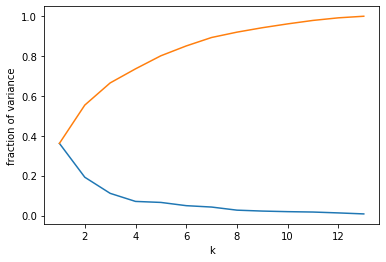

In [38]:
# plot feature and overall percent variance
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(1,len(pct)+1),pct,label='feature')
plt.plot(range(1,len(pv)+1),pv,label='overall')
plt.ylabel('fraction of variance')
plt.xlabel('k')
plt.show()

Now, given an expected percent variance $p$, we choose the number of features $k$ with at least that percent explained variance value in the vector $pv$, i.e., the first dimension whose value is greater or equal to the desired percent. 

## Exercise 2
Create a function that, given the overall percent varience vector plotted in the previous exercise and the expected percent variance $p$, returns the number of latent space dimensions that account for $p$% variance in the data. Print out the number of dimensions for $p \in \{40, 60, 80, 90, 95\}$.

In [39]:
def perck(s, p):
    count = 0
    for i in pv:
        count+=1
        if i>p:
            break
    return count

for p in [40, 60, 80, 90, 95]:
    print("Number of dimensions to account for %d%% of the variance: %d" % (p, perck(pv, p*0.01)))

Number of dimensions to account for 40% of the variance: 2
Number of dimensions to account for 60% of the variance: 3
Number of dimensions to account for 80% of the variance: 5
Number of dimensions to account for 90% of the variance: 8
Number of dimensions to account for 95% of the variance: 10


### Algorithm 2: Computing PCA via the Singular Value Decomposition (SVD)

We can instead compute the PCA trasformation via the SVD of the centered matrix $X = X_{sm}$. However, we will then need to transform the singular values of $X$ into eigenvalues of $X^TX$ before constructing the percent vector. In general, the non-zero singular values of a matrix $X$ are the square roots of the eigenvalues of the square matrix $X^TX$.

In [40]:
U,s,V = np.linalg.svd(X_sm)
# singular values of X are the square roots of the eigenvalues of the square matrix X^TX
print("singular values:        ", s)
print("eigenvalues:            ", (np.sort(np.abs(eig_vals)))[::-1])
print("scaled singular values: ", (s**2/(X_sm.shape[0]-1)))

singular values:         [28.94203422 21.08225141 16.04371561 12.78973645 12.32374195 10.68713954
  9.90368818  7.8760733   7.17081793  6.6828618   6.33958815  5.48097635
  4.28967045]
eigenvalues:             [4.73243698 2.51108093 1.45424187 0.92416587 0.85804868 0.64528221
 0.55414147 0.35046627 0.29051203 0.25232001 0.22706428 0.16972374
 0.10396199]
scaled singular values:  [4.73243698 2.51108093 1.45424187 0.92416587 0.85804868 0.64528221
 0.55414147 0.35046627 0.29051203 0.25232001 0.22706428 0.16972374
 0.10396199]


Since L-1 normalization is invariant to scaling by a constant factor, we can simply apply the *percvar* function to the squared singular values. The result will be equivalent to the one from Algorithm 1.

**Note:** Applying the same technique directly to singular values does not give the same result. In practice, you should base your choice of $k$ on the absolute eigenvalues, which can be theoretically explained as a measure of latent variance in the feature space.

## Exercise 3
Use the `percvar` function to verify that the analysis applied to squared singular values gives the same results as the one based on the covariance matrix. Additionally, verify that the analysis based on absolute singular values does not provide the same results.

In [44]:
def compare_values(a,b):
    for i in range(len(a)):
        if round(a[i],4)!=round(b[i],4):
            return False
    return True

In [45]:
new_s = (s**2/(X_sm.shape[0]-1))
pct1,pv1 = percvar(new_s)
if compare_values(pct,pct1) and compare_values(pv,pv1):
    print("Analysis applied to squared singular values gives the same results")
else:
    print("Analysis applied to squared singular values gives different results")

Analysis applied to squared singular values gives the same results


In [46]:
abs_s = np.abs(s)
pct2,pv2 = percvar(abs_s)
if compare_values(pct,pct2) and compare_values(pv,pv2):
    print("Analysis based on absolute singular values gives the same results")
else:
    print("Analysis based on absolute singular values gives different results")

Analysis based on absolute singular values gives different results
